# Youtube spam classification

Each comment is CLASS labelled as spam (1) or legitimate (0).

## 1. Packages and load data

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

# import statmodels for regression
import statsmodels.api as sm

# load data (specified first column as index column -> index = 0)
spam_data = pd.read_csv('data/TubeSpam_vectorized.csv', sep = ",", index_col = 0)

In [2]:
spam_data.head()

,check,channel,hey,guys,new,leave,like,comment,subscribe,just,...,eminem,lost,musician,megan,fox,extraordinary,moneygq,zonepa,waka,CLASS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.374996,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.517648,0.0,0.0,0.0,0.0,0


## 2. Feature selection

In [3]:
# 241 features total including CLASS label
spam_data.columns

Index(['check', 'channel', 'hey', 'guys', 'new', 'leave', 'like', 'comment',
       'subscribe', 'just',
       ...
       'eminem', 'lost', 'musician', 'megan', 'fox', 'extraordinary',
       'moneygq', 'zonepa', 'waka', 'CLASS'],
      dtype='object', length=241)

In [4]:
# remove CLASS from predictos (features)
features = spam_data.drop(columns = 'CLASS')

# check 240 features remaining instead of 241
features.shape

(1954, 240)

### 2.1 Helper function

The function below is a helper function taken from a [Constructor Learning](https://learning.constructor.org/) course for a cleaner pairplot.

In [5]:
# helper function to annotate the pair plots with correlation coefficients
def corr_annot(x, y, ax=None, **kws):
    # annotate plot with correlation coefficient
    r, _ = st.pearsonr(x, y)
    ax = ax or plt.gca()
    fontsizes = {range(0,21):"medium", range(21,51):'large', range(51,81):'x-large', range(90,101):'xx-large'}

    # if r > 0 display corr
    if r > 0:
        font_size = [fontsize for bound,fontsize in fontsizes.items() if round(abs(r), 1)*100 in bound][0]
        ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize = font_size)

### 2.2 Top 3 positively correlated

In [6]:
# n top features to select
n=3

# pearson correlation for all features
corr = features.corr(method = "pearson")
corr = corr.mask(corr.apply(lambda x: x.name == x.index))

# filter only most correlated ascending false
most_correlated = corr.unstack(
    ).drop_duplicates(
      ).sort_values(ascending = False)[:n]

most_correlated

subscribe  need     0.937173
dont       wow      0.917538
time       sorry    0.899743
dtype: float64

In [7]:
# indentify columns of interest
columns_of_interest = np.unique(
    [i for j in most_correlated.index.to_list() for i in j]
    )

columns_of_interest

array(['dont', 'need', 'sorry', 'subscribe', 'time', 'wow'], dtype='<U9')

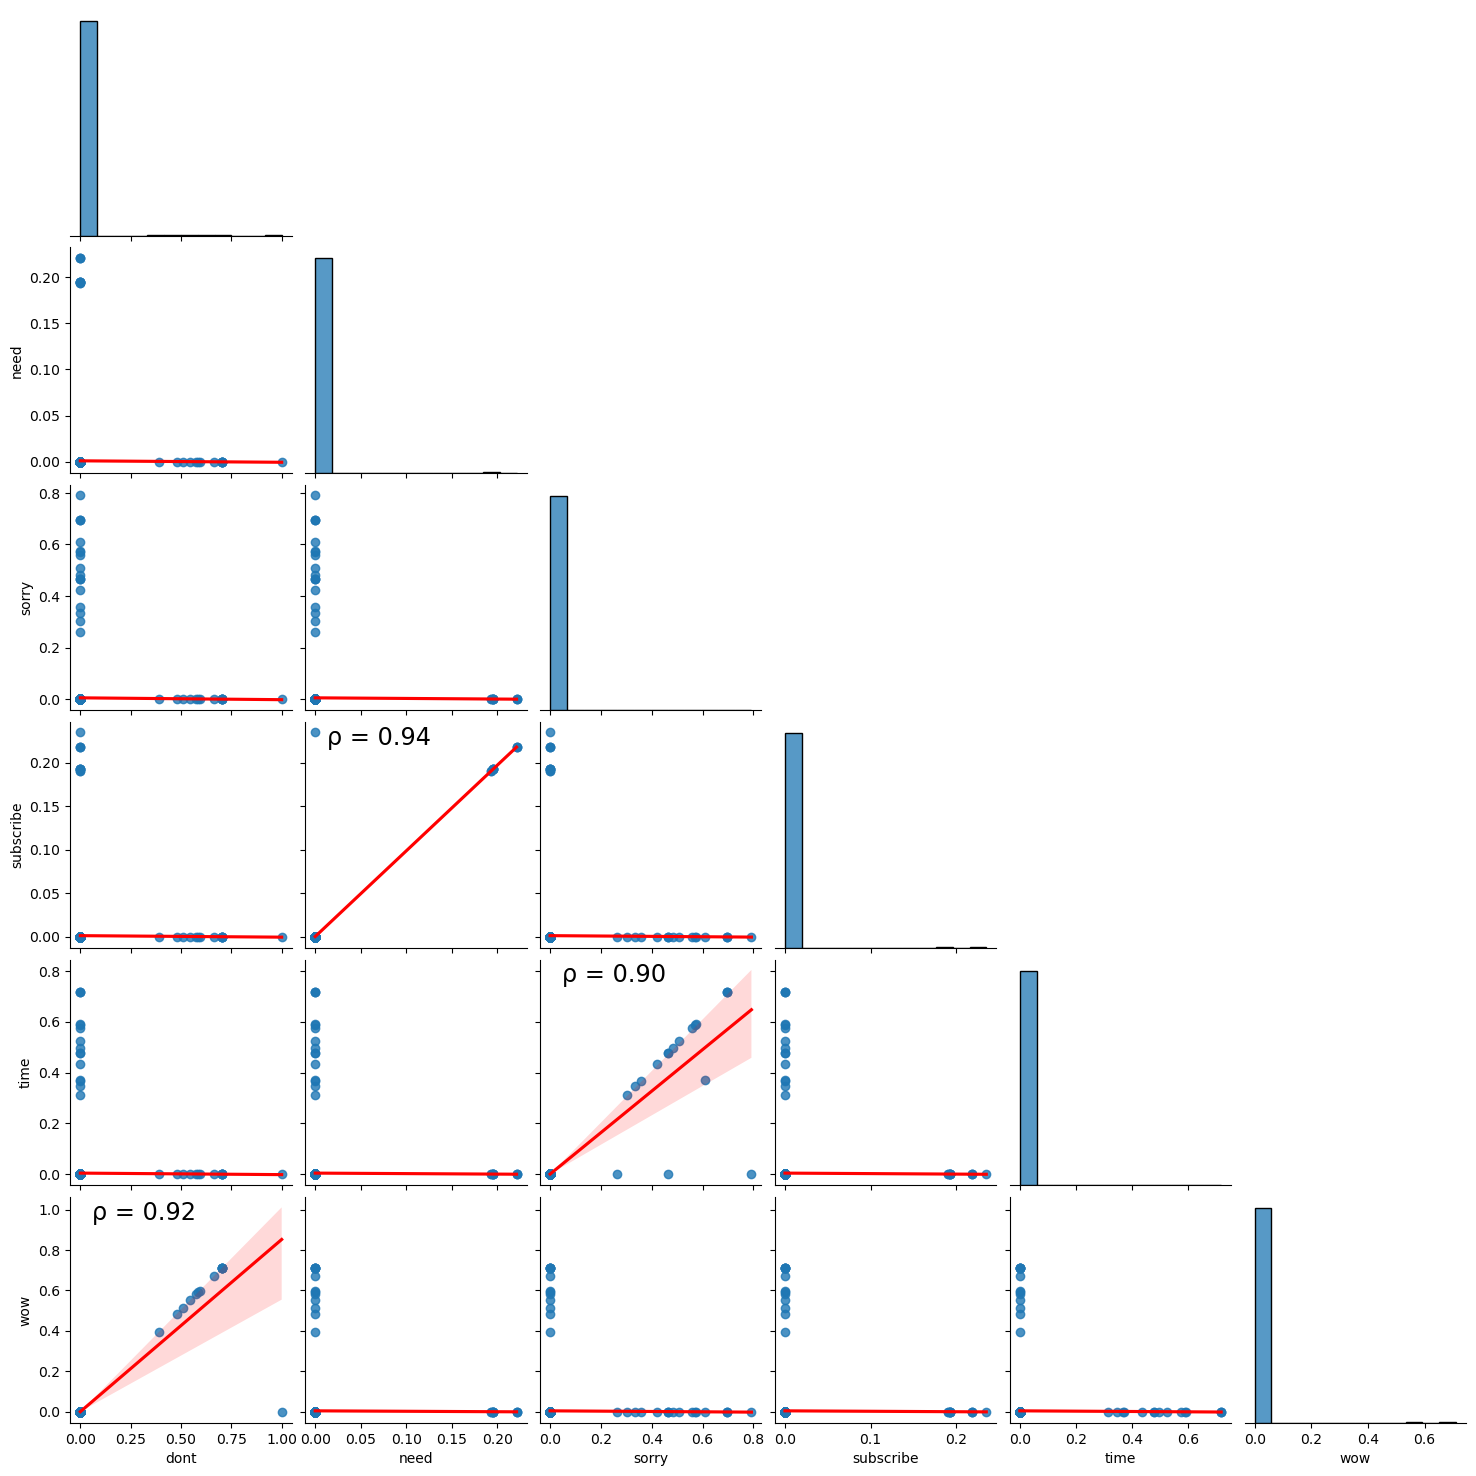

In [8]:
# features only in columns_of_interest
corr_example = features[columns_of_interest]

# pairplot selected columns_of_interest
g = sns.pairplot(corr_example, kind = "reg", corner = True, plot_kws = {'line_kws':{'color':'red'}});

g.map_lower(corr_annot);

### 2.3 Least correlated

In [9]:
# filter only least correlated ascending TRUE
least_correlated = corr.unstack(
    ).drop_duplicates(
      ).sort_values(ascending = True)[:n]

least_correlated

https  live     -0.142460
       know     -0.115266
live   zonepa   -0.113649
dtype: float64

In [10]:
# indentify columns of interest
columns_of_interest = np.unique(
    [i for j in least_correlated.index.to_list() for i in j]
    )

columns_of_interest

array(['https', 'know', 'live', 'zonepa'], dtype='<U6')

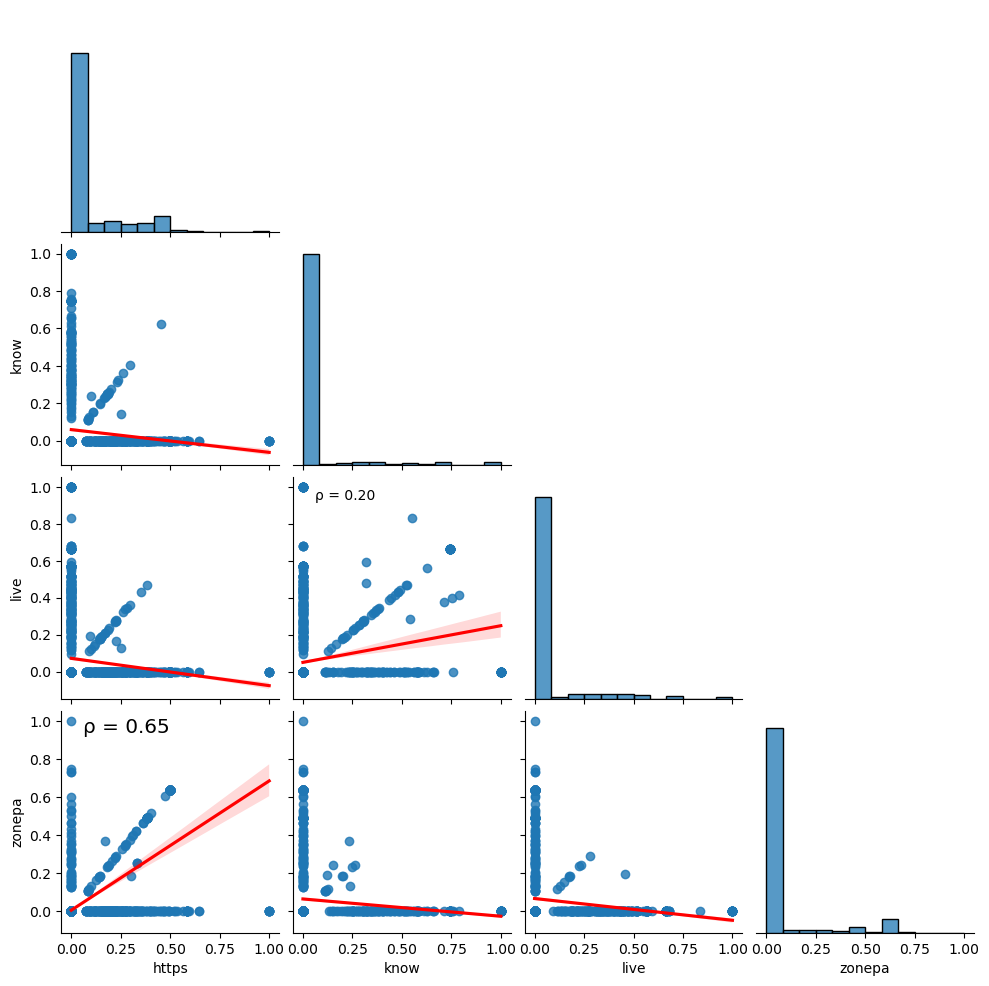

In [11]:
# features only in columns_of_interest
corr_example = features[columns_of_interest]

# pairplot selected columns_of_interest
g = sns.pairplot(corr_example, kind = "reg", corner = True, plot_kws = {'line_kws':{'color':'red'}});

g.map_lower(corr_annot);

### 2.4 Correlation between 40 and 80% (3 random correlations)

In [12]:
# filter only least correlated ascending TRUE
randomly_correlated = corr.abs(
  ).unstack(
    ).drop_duplicates(
      ).where(
          lambda x:  (x >= 0.4) & (x <= 0.8)
      ).dropna(
        ).sample(
            n)

randomly_correlated

im     click    0.626097
       hit      0.686503
gonna  crazy    0.727498
dtype: float64

In [13]:
# indentify columns of interest
columns_of_interest = np.unique(
    [i for j in randomly_correlated.index.to_list() for i in j]
    )

columns_of_interest

array(['click', 'crazy', 'gonna', 'hit', 'im'], dtype='<U5')

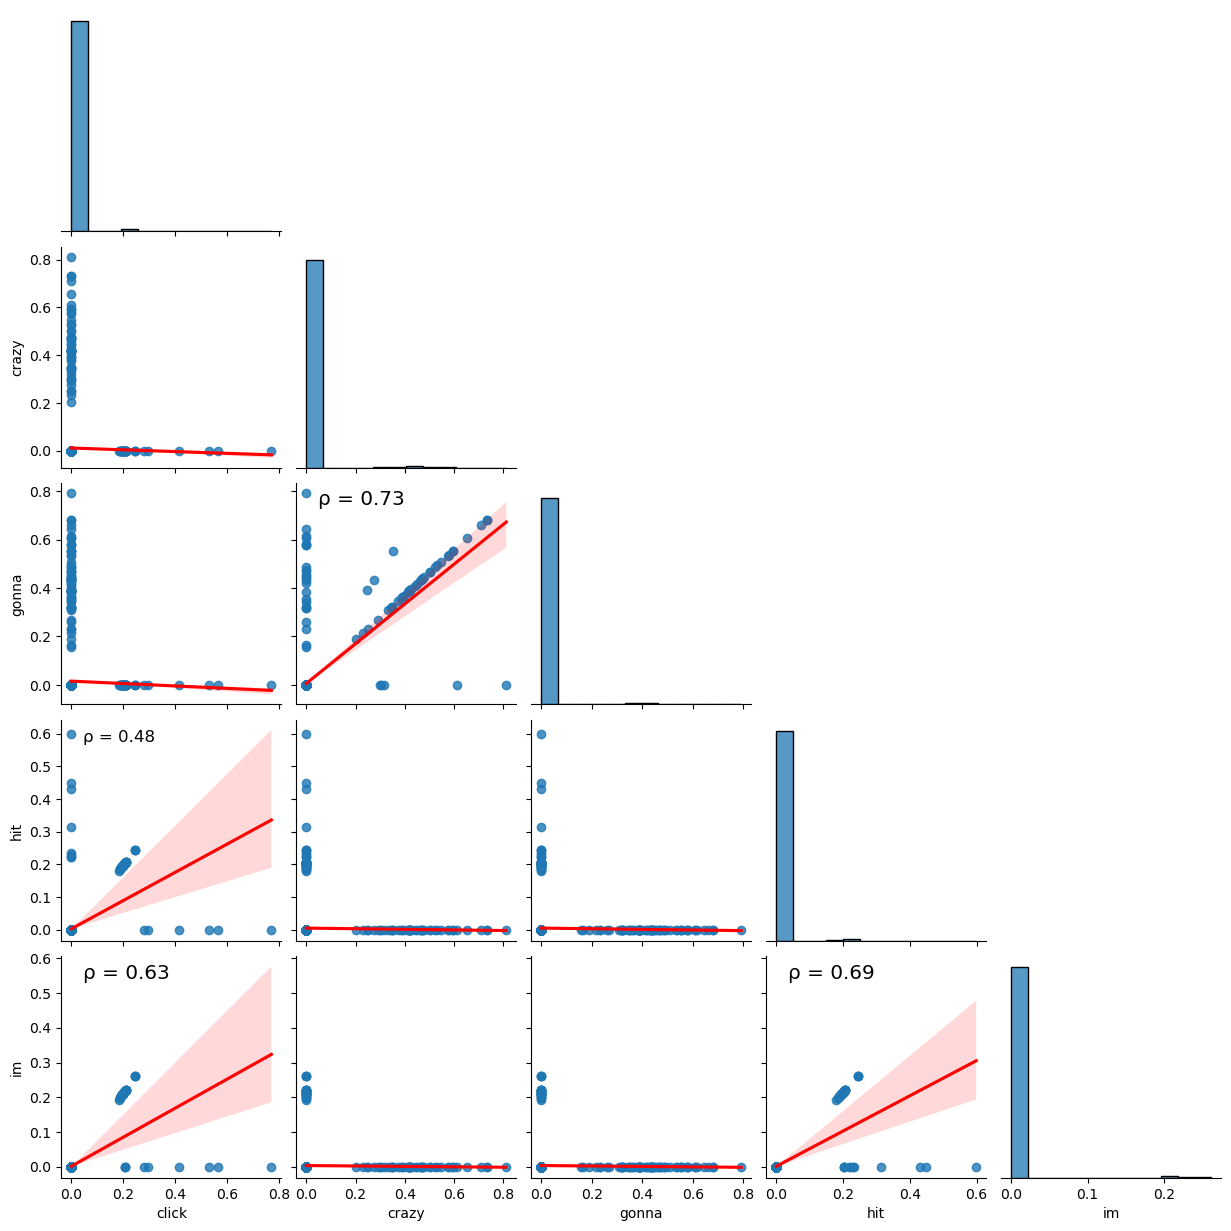

In [14]:
# features only in columns_of_interest
corr_example = features[columns_of_interest]

# pairplot selected columns_of_interest
g = sns.pairplot(corr_example, kind = "reg", corner = True, plot_kws = {'line_kws':{'color':'red'}});

g.map_lower(corr_annot);

### 2.5 Combine all previously calculated correlations for selected features

Most representative columns are:  click, crazy, dont, gonna, hit, https, im, know, live, need, sorry, subscribe, time, wow, zonepa


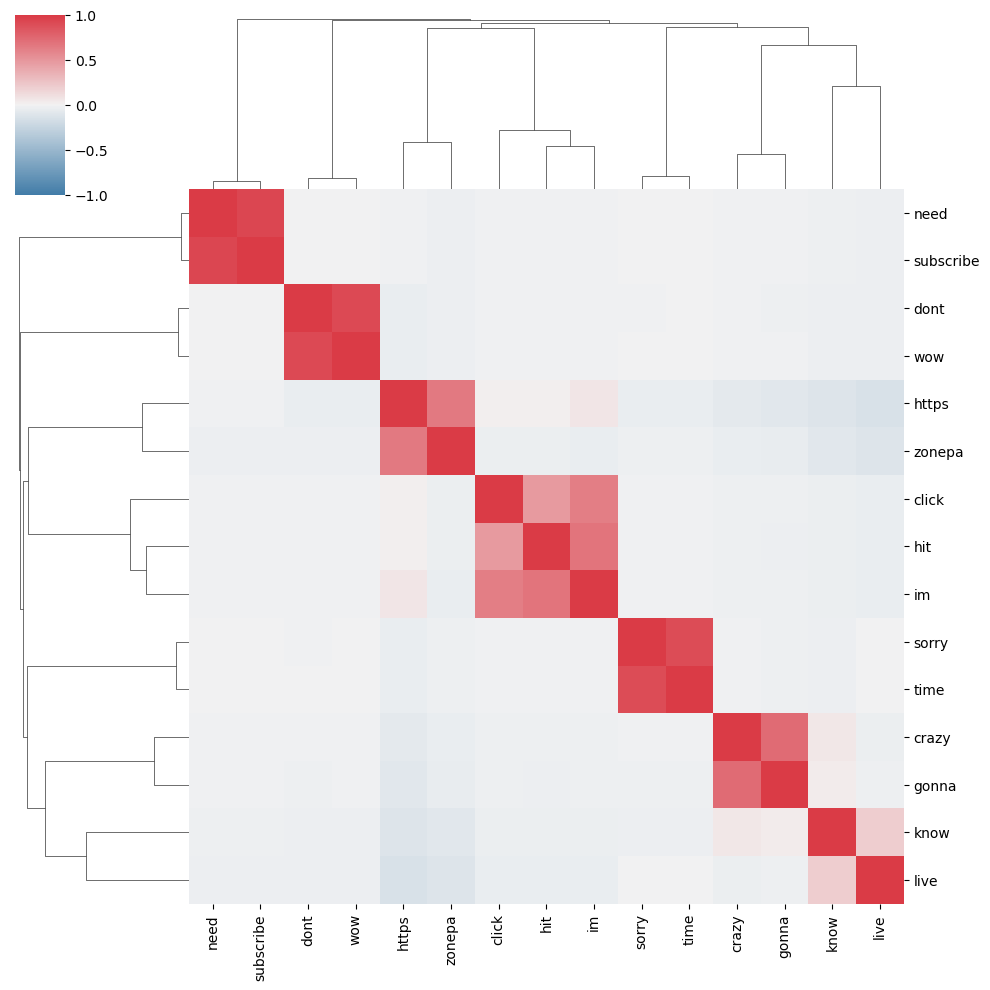

In [15]:
# collect all the columns of interest for the correlation among the features just calculated

# indentify columns of interest
columns_of_interest = np.unique(
    # top 3 most
    [i for j in most_correlated.index.to_list() for i in j] \
    # 1 least
    + [i for j in least_correlated.index.to_list() for i in j] \
    # 3 random 40-80%
    + [i for j in randomly_correlated.index.to_list() for i in j]
    )

# output
print('Most representative columns are: ', ', '.join(columns_of_interest))

# features only in columns_of_interest
corr_example = features[columns_of_interest]

# correlations
x = corr_example.corr()
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# cluster map
sns.clustermap(
    x,
    vmin = -1,
    vmax = 1,
    cmap = cmap);

## 3. Logistic regression on feature selection

### 3.1 Helper function

The function below is a helper function taken from a [Constructor Learning](https://learning.constructor.org/) course to check the performance of different models and calculate time elapsed.

In [16]:
# packages to track time elapsed
from time import time 
import warnings

# GLM function regression
def glm_estimate(data = None, features = None, pred_class = None, print_run = True):
    
    # class to predict (response variable)
    y = data[pred_class]
    
    # features selected (explanatory variables)
    X = data.drop(columns = pred_class) if features is None else data.drop(columns = pred_class)[features]

    # track time elapsed
    start_time = time()

    # logit model
    logit_model = sm.GLM(
        y,
        sm.add_constant(X),
        family=sm.families.Binomial(
            link=sm.genmod.families.links.logit()
            )
        )
    
    # model fit
    results = logit_model.fit(
        disp = True,
        method='bfgs',
        maxiter=1000
        )

    # stop time elapsed
    end_time = time()
    time_elapsed = end_time - start_time
    
    # store AIC performance
    AIC_current = results.aic

    # print if print_run is True
    if print_run is True:
        print(f'Time taken: {time_elapsed}. AIC: {AIC_current}. # of features: {len(X.columns)}')

    return results

### 3.2 All default features

In [17]:
# 240 features
results = glm_estimate(data = spam_data, pred_class = 'CLASS')

Optimization terminated successfully.
         Current function value: 0.312608
         Iterations: 673
         Function evaluations: 676
         Gradient evaluations: 676
Time taken: 1.1776399612426758. AIC: 1703.6714066362515. # of features: 240


In [18]:
# results summary with 240 features
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  CLASS   No. Observations:                 1954
Model:                            GLM   Df Residuals:                     1713
Model Family:                Binomial   Df Model:                          240
Link Function:                  logit   Scale:                          1.0000
Method:                          bfgs   Log-Likelihood:                -610.84
Date:                Thu, 11 May 2023   Deviance:                       1221.7
Time:                        15:58:09   Pearson chi2:                 2.01e+03
No. Iterations:                     0   Pseudo R-squ. (CS):             0.5325
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.1064      0.239     -8.829      0.000      -2.574      -1.639
check            -1.4782      1.772     -0.834      0.404      -4.952       1.996
channel           0.2919      5.419      0.054      0.957     -10.330      10.914
hey              -3.8475      3.847     -1.000      0.317     -11.388       3.693
guys             -8.7538      4.451     -1.967      0.049     -17.478      -0.029
new               0.6410      1.585      0.404      0.686      -2.466       3.748
leave             1.1100      0.740      1.500      0.134      -0.341       2.561
like              1.0710      0.674      1.589      0.112      -0.250       2.392
comment           3.4644      3.076      1.126      0.260      -2.564       9.493
subscribe        25.5122    111.123      0.230      0.818    -192.285     243.309
just              0.2130      1.523      0.140      0.889      -2.773       3.199
say               3.2842      1.059      3.100      0.002       1.208       5.361
com               1.2805      1.572      0.815      0.415      -1.800       4.361
sexy             -7.6155      4.233     -1.799      0.072     -15.913       0.682
enjoy            20.1870     31.798      0.635      0.526     -42.136      82.510
watch             1.9601      1.877      1.044      0.296      -1.719       5.639
website           2.0385      3.073      0.663      0.507      -3.985       8.062
site              1.5864      0.614      2.586      0.010       0.384       2.789
soon              3.7463      1.186      3.159      0.002       1.422       6.071
came              1.5438      0.689      2.241      0.025       0.194       2.894
views            -1.0578      2.141     -0.494      0.621      -5.254       3.139
funny            -0.2646      0.687     -0.385      0.700      -1.611       1.082
videos            1.2818      1.283      0.999      0.318      -1.233       3.796
tell             -0.4734      1.659     -0.285      0.775      -3.725       2.778
started          -7.0610      3.767     -1.874      0.061     -14.445       0.323
reading           3.8118      2.620      1.455      0.146      -1.322       8.946
stop              2.0928      1.721      1.216      0.224      -1.280       5.466
day             -34.7482    110.203     -0.315      0.753    -250.742     181.246
want             -1.0212      3.248     -0.314      0.753      -7.387       5.345
right             3.5460      0.805      4.405      0.000       1.968       5.124
https             5.2030      0.762      6.828      0.000       3.710       6.696
twitter           7.8335      5.164      1.517      0.129      -2.287      17.954
hello             0.4828      1.865      0.259      0.796      -3.173       4.139
lyrics            0.7275      1.183      0.615      0.538      -1.591       3.046
ve               -0.9311      2.178     -0.428   

### 3.3 Drop most correlated features

The idea here is that when the correlation between 2 features is very high, dropping one and keeping the other would have basically the same impact on the model. Let's find the most correlated features with a positive correlation above 0.8.

In [19]:
# features correlation above 0.8
most_correlated_80perc = corr.unstack(
    ).drop_duplicates(
      ).where(
          lambda x: (x >= 0.8)
      ).dropna(
        )

most_correlated_80perc

subscribe  need     0.937173
im         way      0.826827
dont       wow      0.917538
time       sorry    0.899743
need       good     0.838511
dtype: float64

In [20]:
# prepare the data 
cols_to_drop = np.unique(
    [i for j in most_correlated_80perc.index.to_list() for i in j]
    )

# features with not high correlation
non_highcorr_features = spam_data.drop(columns = cols_to_drop)

# run model without features with 0.8+ corr
results = glm_estimate(data = non_highcorr_features, pred_class = 'CLASS')

Optimization terminated successfully.
         Current function value: 0.321485
         Iterations: 520
         Function evaluations: 523
         Gradient evaluations: 523
Time taken: 0.8312768936157227. AIC: 1720.36196226179. # of features: 231


### 3.4 Combined most correlated features

Here we combine the most correlated features (subscribe and need) and remove the 2 variables.

In [21]:
# select most correlated features
most_corr_pair = most_correlated_80perc.index[0]
most_corr_pair

('subscribe', 'need')

In [22]:
# get combined features min, max and average
combined_features = np.maximum(
    spam_data[most_corr_pair[0]],
    spam_data[most_corr_pair[1]]
    )

# create new column
new_col_name = most_corr_pair[0] + '.' + most_corr_pair[1]

# add new column to non_highcorr_features
non_highcorr_features[new_col_name] = combined_features

In [23]:
# run model
results = glm_estimate(data = non_highcorr_features, pred_class = 'CLASS')

Optimization terminated successfully.
         Current function value: 0.319685
         Iterations: 686
         Function evaluations: 690
         Gradient evaluations: 690
Time taken: 1.1062588691711426. AIC: 1715.327602681237. # of features: 232


## 4. Features selection based on P-value

### 4.1 Find significant features

Let's fit the model and select only the features that are significant for the model (p-value < 0.05).

In [24]:
# run model
model = glm_estimate(data = non_highcorr_features, pred_class = 'CLASS')

# features p-values
pval = model.pvalues[1:]

# p-values significant threshold
pval_selected = pval[pval < 0.05]

# add p-values to features selected
pval_selected_columns = pval_selected.index.to_list()
pval_selected_columns

Optimization terminated successfully.
         Current function value: 0.319685
         Iterations: 686
         Function evaluations: 690
         Gradient evaluations: 690
Time taken: 1.093991994857788. AIC: 1715.327602681237. # of features: 232


['say',
 'site',
 'soon',
 'came',
 'right',
 'https',
 'cover',
 'music',
 '100',
 'rap',
 'plz',
 'chance',
 'play',
 '0',
 'type',
 'lt',
 'google',
 'amazing',
 'join',
 'dance',
 'earth',
 'fucking',
 'link',
 'hear',
 'life',
 'perry',
 '15',
 'probably',
 'lmfao',
 'home',
 'working',
 'shakira',
 'lost',
 'zonepa']

### 4.2 Fit model with only significant features

In [25]:
# number of significant features
len(pval_selected_columns)

34

In [26]:
# paste combined into data frame
pval_selected_features = spam_data[pval_selected_columns + ['CLASS']]

# run model
reduced_space_model = glm_estimate(data = pval_selected_features, pred_class= 'CLASS')

# print summary
reduced_space_model.summary()

Optimization terminated successfully.
         Current function value: 0.412050
         Iterations: 173
         Function evaluations: 174
         Gradient evaluations: 174
Time taken: 0.06384992599487305. AIC: 1680.292587777432. # of features: 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  CLASS   No. Observations:                 1954
Model:                            GLM   Df Residuals:                     1919
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          bfgs   Log-Likelihood:                -805.15
Date:                Thu, 11 May 2023   Deviance:                       1610.3
Time:                        15:58:13   Pearson chi2:                 2.46e+03
No. Iterations:                     0   Pseudo R-squ. (CS):             0.4296
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5559      0.091    -17.079      0.000      -1.734      -1.377
say            2.4591      0.921      2.669      0.008       0.653       4.265
site           0.9938      0.553      1.797      0.072      -0.090       2.078
soon           2.4859      0.957      2.597      0.009       0.609       4.362
came           0.7704      0.643      1.198      0.231      -0.490       2.031
right          3.1372      0.660      4.750      0.000       1.843       4.432
https          5.7927      0.587      9.868      0.000       4.642       6.943
cover          3.7198      0.790      4.708      0.000       2.171       5.268
music          1.8558      1.135      1.636      0.102      -0.368       4.080
100            3.1608      2.286      1.383      0.167      -1.319       7.641
rap            6.0385      2.080      2.903      0.004       1.962      10.115
plz            5.3695      1.647      3.261      0.001       2.142       8.597
chance         6.1135      0.946      6.465      0.000       4.260       7.967
play          12.7186      3.114      4.084      0.000       6.615      18.822
0              1.0285      0.399      2.575      0.010       0.246       1.811
type           2.9343      0.981      2.992      0.003       1.012       4.856
lt             2.6298      0.834      3.152      0.002       0.995       4.265
google        -3.8209      2.650     -1.442      0.149      -9.015       1.373
amazing        5.5991      1.192      4.697      0.000       3.263       7.936
join          -2.9721      2.187     -1.359      0.174      -7.258       1.314
dance          2.6934      0.907      2.968      0.003       0.915       4.472
earth          2.2227      1.572      1.414      0.157      -0.858       5.303
fucking        5.2695      1.200      4.390      0.000       2.917       7.622
link           5.2027      0.587      8.857      0.000       4.051       6.354
hear           8.4804      1.886      4.497      0.000       4.784      12.176
life           3.2296      1.110      2.910      0.004       1.054       5.405
perry          1.9752      0.842      2.346      0.019       0.325       3.625
15            -2.1661      2.143     -1.011      0.312      -6.366       2.034
probably       3.5138      1.130      3.110      0.002       1.300       5.728
lmfao         -4.0636      1.009     -4.029      0.000      -6.040      -2.087
home           3.8393      1.232      3.117      0.002       1.425       6.253
working        0.9811      0.606      1.620      0.105      -0.206       2.168
shakira        2.0758      0.790      2.628      0.009       0.528       3.624
lost          13.1572      5.196      2.532      0.011       2.972      23.342
zonepa         2.7223      0.581      4.684      0.000       1.583       3.862
==============================================================================
""

### 4.3 Find best model by stepwise AIC procedure

In [27]:
# helper function taken from Constructor Learning

from IPython.display import clear_output

def stepwise_selection(data,
                       pred_class,
                       initial_list=[], 
                       aic_step_min = 2, 
                       #pval_threshold = 0.05, 
                       verbose=True):
    """ Perform a forward feature selection 
    based on AIC values from statsmodels.api.GLM.
    """
    
    y = data[pred_class]
    X = data.drop(columns = pred_class)
    included = list(initial_list)

    # Forward step
    def forward_step(y, X, included):
      while True:
        changed = False
        excluded = list(set(X.columns)-set(included))
        new_aic = pd.Series(index=excluded)
        for new_column in excluded:

            model = sm.GLM(y,
                            sm.add_constant(X[included + [new_column]]),
                                              family=sm.families.Binomial(
                                                  link=sm.genmod.families.links.logit()
                                                  )
                                              ).fit(method='bfgs',maxiter=1000)

            new_aic[new_column] = model.aic
        best_aic = new_aic.min()
        if abs(best_aic - new_aic.iloc[-1]) > aic_step_min and len(new_aic) > 1:
            clear_output(wait=True)
            best_feature = new_aic.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:20} Current  AIC: {:.6}'.format(best_feature, best_aic))
        if not changed:
            break
      print("Best AIC: {:.6}".format(best_aic))
      return (best_aic, included, model)

    return forward_step(y, X, included)

In [29]:
# run model stepwise_selection
best_aic, features, model = stepwise_selection(pval_selected_features, pred_class = "CLASS")

# print results
print(best_aic, features, model.params)

Add  zonepa               Current  AIC: 1751.43


/var/folders/q0/yzzvs92s18169djfs6dhj5lm0000gn/T/ipykernel_9885/1747072043.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_aic = pd.Series(index=excluded)


Best AIC: 1739.93
1739.929010656325 ['https', 'lost', 'link', 'play', 'chance', 'hear', 'lmfao', 'cover', 'amazing', 'right', 'rap', 'fucking', 'plz', 'zonepa'] const       -1.212702
https        5.531759
lost        12.910020
link         5.009496
play        11.927405
chance       5.473815
hear         8.352122
lmfao       -4.474543
cover        3.995703
amazing      5.998697
right        3.367093
rap          5.863570
fucking      4.861097
plz          5.673845
zonepa       2.462957
probably     3.537811
dtype: float64


In [30]:
print(f'Features used in best model (AIC: {best_aic}):')
print('----------------')
print(features)
print('----------------')
print(model.summary())

Features used in best model (AIC: 1739.929010656325):
----------------
['https', 'lost', 'link', 'play', 'chance', 'hear', 'lmfao', 'cover', 'amazing', 'right', 'rap', 'fucking', 'plz', 'zonepa']
----------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CLASS   No. Observations:                 1954
Model:                            GLM   Df Residuals:                     1938
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          bfgs   Log-Likelihood:                -854.01
Date:                Thu, 11 May 2023   Deviance:                       1708.0
Time:                        15:58:32   Pearson chi2:                 2.60e+03
No. Iterations:                     0   Pseudo R-squ. (CS):             0.4003
Covariance Type:            nonrobust                                       